In [1]:
import os
import re
import zipfile

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from PIL import ImageFilter
import ast
import json
from glob import glob

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn

In [2]:
torch.cuda.is_available()

True

In [3]:
padded_image_shape = (1024, 1920)
anchor_k = 9
num_classes = 80#
num_classes_real = 5
max_data_m = 100
use_zoom_up_data = False
level_start = 3
level_end = 3+5
l1 = 1e-9
activation = 'relu'#'selu' is not converted to tflite
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)
class_names = ['bg', '"water"', '"waterf"', '"land"', '"animal"']
folder_root_water = '/home/mvlab/Downloads/dataset/Water/'
path_csv = folder_root_water + 'via_project_20200914.csv'
folder_water_image = folder_root_water
folder_weather = '/home/mvlab/Downloads/weather/'
path_weight = "model/water"
is_debug = False
os.path.isdir(folder_water_image)

True

In [4]:
folder_ped = '/home/mvlab/Downloads/dataset/PennFudanPed/'
folder_ped_rgb = 'PNGImages/'
folder_ped_mask = 'PedMasks/'
os.path.isdir(folder_ped), os.path.isdir(folder_ped+folder_ped_rgb), os.path.isdir(folder_ped+folder_ped_mask)

(True, True, True)

In [5]:
def convert_path_rgb_to_path_mask(path_rgb):
    path_file_name = path_rgb.split('/')[-1]
    file_name_pre = path_file_name.split('.')[0]
    path_mask = folder_ped + folder_ped_mask + file_name_pre + '_mask' + '.png'
    if os.path.isfile(path_mask):
        return path_mask
    else:
        print('not exist file', path_mask)
        exit()

170 170


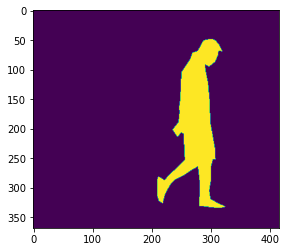

In [6]:
path_rgbs = glob(folder_ped + folder_ped_rgb + '*.*')
len(path_rgbs), path_rgbs[0], path_rgbs[-1]
path_masks = []
for path_rgb in path_rgbs:
    path_masks.append(convert_path_rgb_to_path_mask(path_rgb))
print(len(path_rgbs), len(path_masks))
plt.imshow(Image.open(path_masks[0]))

In [7]:
def get_masked_pedestrian(path_rgbs, path_masks):
    arr_ped_list = []
    m = len(path_rgbs)
    for i in range(m):
        path_rgb = path_rgbs[i]
        path_mask = path_masks[i]
        img_rgb = Image.open(path_rgb)
        img_rgb = img_rgb.filter(ImageFilter.GaussianBlur(radius=3))
        img_mask = Image.open(path_mask)
        arr_rgb = np.array(img_rgb)
        arr_mask = np.array(img_mask)
        mask_max_v = np.max(arr_mask)
        img_h, img_w = arr_mask.shape
        #print(i, 'mask_max_v', mask_max_v, np.unique(arr_mask), 'img_h, img_w', img_h, img_w)
        if np.min(arr_rgb) < 1:
            #print('rgb min value is', np.min(arr_rgb), np.max(arr_rgb), path_rgb)
            arr_rgb = np.maximum(arr_rgb, np.ones_like(arr_rgb))
            
        arr_mask_3d = np.expand_dims((arr_mask > 0).astype(np.uint8), -1)
        arr_rgb_masked = arr_rgb * arr_mask_3d
        for j in range(1, 1 + mask_max_v):
            ped_mask_j = arr_mask == j
            ped_mask_sum_0 = np.any(ped_mask_j, axis=0)
            ped_mask_sum_1 = np.any(ped_mask_j, axis=1)
            ped_mask_sum_0 = ped_mask_sum_0.astype(np.int)
            ped_mask_sum_1 = ped_mask_sum_1.astype(np.int)
           
            x0 = np.argmax(ped_mask_sum_0)
            x1 = img_w - np.argmax(ped_mask_sum_0[::-1])
            y0 = np.argmax(ped_mask_sum_1)
            y1 = img_h - np.argmax(ped_mask_sum_1[::-1])            
            #print(ped_mask_j.shape, np.sum(ped_mask_j), x0, x1, y0, y1)            
            arr_ped_j = arr_rgb_masked[y0:y1, x0:x1]
            arr_ped_list.append(arr_ped_j)
        
        if i%100==0:print(i, len(arr_ped_list))
    return arr_ped_list

0 1
100 252
len 423


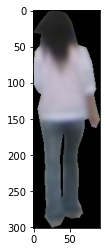

In [8]:
ped_list = get_masked_pedestrian(path_rgbs, path_masks)
print('len', len(ped_list))
p = plt.imshow(ped_list[2]) 

In [9]:
folder_water_image, os.path.isdir(folder_water_image)

('/home/mvlab/Downloads/dataset/Water/', True)

(1920, 1080)


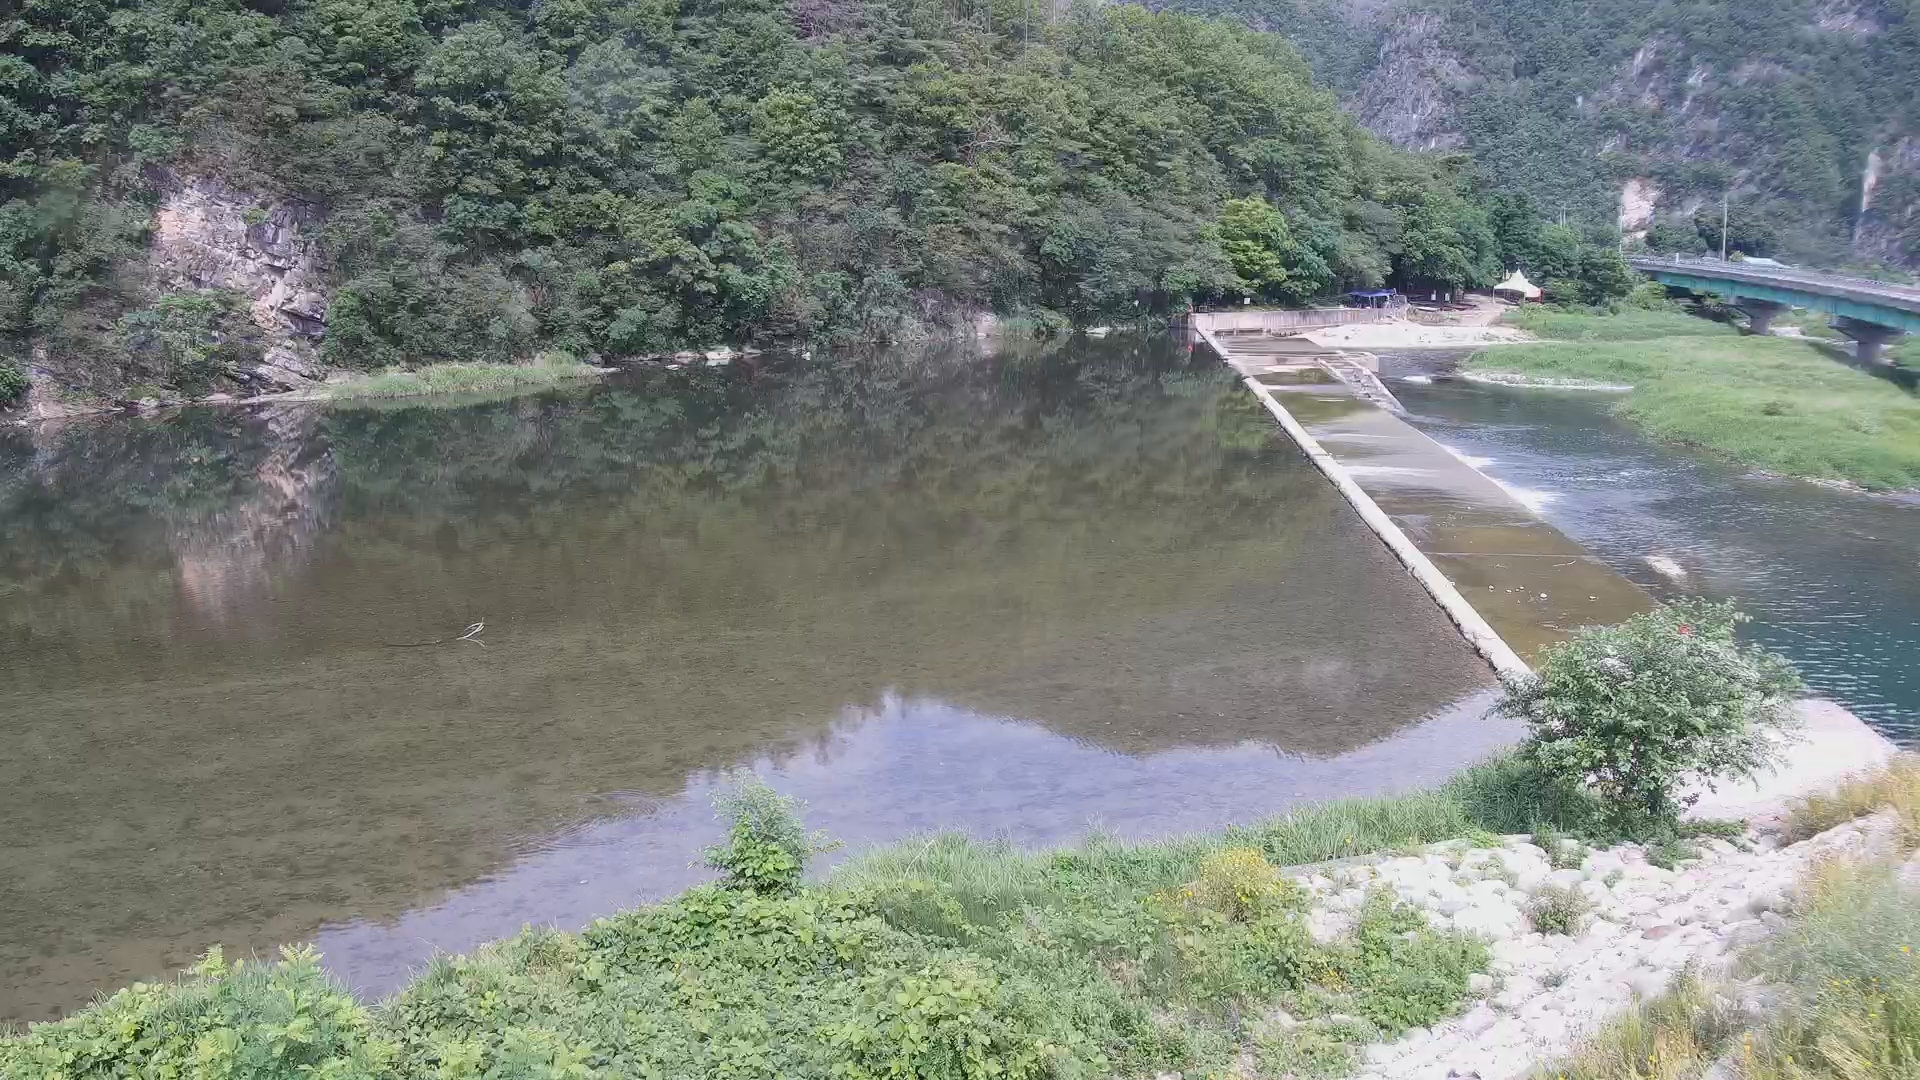

In [10]:
img_water_path = folder_water_image + '00222.png'
img_water = Image.open(img_water_path)
print(img_water.size)
img_water

In [11]:
def append_pedestrin_to_water(ped_arrs, img_water, range_width = (14, 30)):
    m = len(ped_arrs)
    water_arr = np.array(img_water)
    mask_arr = np.zeros_like(water_arr[:, :, 0])
    labels = []
    img_h, img_w, img_c = water_arr.shape
    top_offset_y0 = int(img_h * 0.03) 
    top_offset_y1 = int(img_h * 0.25) 
    top_offset_x0 = int(img_w * 0.03) 
    top_offset_x1 = int(img_w * 0.8) 
    water_offset_y0 = int(img_h * 0.4) 
    water_offset_y1 = int(img_h * 0.8) 
    water_offset_x0 = int(img_w * 0.03) 
    water_offset_x1 = int(img_w * 0.65) 
    land_offset_y0 = int(img_h * 0.91) 
    land_offset_y1 = int(img_h * 0.98) 
    land_offset_x0 = int(img_w * 0.05) 
    land_offset_x1 = int(img_w * 0.95)         
    
    last_i = 0
    def append_object(offset_x0, offset_x1, offset_y0, offset_y1, cls, last_i, is_crop=False):
        tx = 0
        ty = 0
        for i in range(last_i, m):
            ped_arr = ped_arrs[i]
            #print(i, ped_arr.shape)
            ped_h = ped_arr.shape[0]
            ped_h_a = 1.6
            if is_crop:
                ped_h_a = 1.0
                ped_arr = ped_arr[:ped_h//2]
                
            ped_img = Image.fromarray(ped_arr)
            ped_w = np.random.randint(range_width[0], range_width[1])
            ped_h = int(ped_w * ped_h_a)

            ped_img = ped_img.resize((ped_w, ped_h))
            #ped_img = ped_img.filter(ImageFilter.GaussianBlur(radius=3))
            ped_arr = np.array(ped_img)
            y0 = offset_y0 + ty
            y1 = y0 + ped_h
            x0 = offset_x0 + tx
            x1 = x0 + ped_w
            water_crop = water_arr[y0:y1, x0:x1]
            ped_mask = (ped_arr > 1).astype(np.uint8)
            #print('ped_arr', ped_arr.shape, 'water_crop', water_crop.shape)
            try:
                ped_arr = ped_arr + water_crop * (1 - ped_mask)
            except:
                print('ped_arr', ped_arr.shape, 'water_crop', water_crop.shape)
                break
                
            water_arr[y0:y1, x0:x1] = ped_arr
            mask_arr[y0:y1, x0:x1] = ped_mask[:, :, 0]
            waterf = cls
            margin = 2
            bx0 = 1.0 * (x0 - margin)/img_w
            by0 = 1.0 * (y0 - margin)/img_h
            bx1 = 1.0 * (x1 + margin)/img_w
            by1 = 1.0 * (y1 + margin)/img_h
            cbbox = np.array([waterf, bx0, by0, bx1, by1])
            labels.append(cbbox)

            tx += (x1 - x0) * 2
            if tx > offset_x1:
                tx = 0
                ty += int(range_width[1]*1.9)

            if offset_y0 + ty > offset_y1*0.95:
                last_i = i
                print(m, last_i, 'break')
                break
        return last_i
    
    last_i = append_object(top_offset_x0, top_offset_x1, top_offset_y0, top_offset_y1, 3, last_i)
    last_i = append_object(water_offset_x0, water_offset_x1, water_offset_y0, water_offset_y1, 2, last_i, is_crop=True)
    last_i = append_object(land_offset_x0, land_offset_x1, land_offset_y0, land_offset_y1, 3, last_i)
    
    
    labels = np.stack(labels)
    mask_bool = mask_arr.astype(np.bool)
    return water_arr, mask_bool, labels

423 82 break
423 196 break
423 228 break
mask_cbbox 1


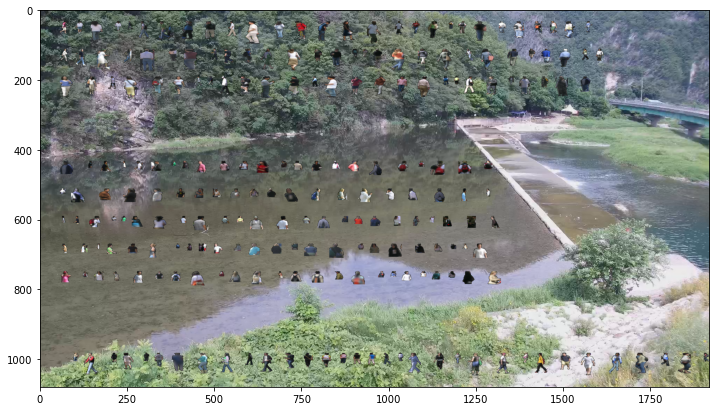

In [12]:
water_with_ped, water_mask, mask_cbbox = append_pedestrin_to_water(ped_list, img_water,range_width = (14, 42))
water_with_ped = np.expand_dims(water_with_ped, 0)
water_mask = np.expand_dims(water_mask, 0)
mask_cbbox = np.expand_dims(mask_cbbox, 0)
print('mask_cbbox', len(mask_cbbox))
plt.figure(figsize=(12,10))
plt.imshow(water_with_ped[0])

water_mask (1, 1080, 1920) bool


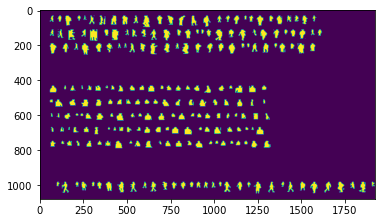

In [13]:
print('water_mask', water_mask.shape, water_mask.dtype)
plt.imshow(water_mask[0])

In [14]:
use_weather_effect = os.path.isdir(folder_weather)
use_weather_effect

False

In [15]:
img_paths = glob(folder_water_image + '*.*')
len(img_paths)

1197

In [16]:
weather_images = []
if use_weather_effect:
    path_weathers = glob(folder_weather + '*.*')
    if len(path_weathers)>0:
        for path_weather in path_weathers:            
            image = Image.open(path_weather) 
            weather_images.append(image)            
            plt.imshow(image)
            plt.show()

In [17]:
df = pd.read_csv(path_csv)
df.shape

(3308, 7)

In [18]:
df.head()

filename  file_size file_attributes  region_count  region_id  \
0  00001.png    3697347              {}             5          0   
1  00001.png    3697347              {}             5          1   
2  00001.png    3697347              {}             5          2   
3  00001.png    3697347              {}             5          3   
4  00001.png    3697347              {}             5          4   

                             region_shape_attributes  \
0  {"name":"rect","x":1472,"y":735,"width":25,"he...   
1  {"name":"rect","x":1735,"y":627,"width":21,"he...   
2  {"name":"rect","x":1501,"y":461,"width":20,"he...   
3  {"name":"rect","x":1339,"y":407,"width":13,"he...   
4  {"name":"rect","x":1356,"y":408,"width":14,"he...   

            region_attributes  
0  {"object":{"waterf":true}}  
1   {"object":{"water":true}}  
2   {"object":{"water":true}}  
3   {"object":{"water":true}}  
4   {"object":{"water":true}}

In [19]:
df['filename'].nunique()

1355

In [20]:
annotation = dict()
for i in range(len(df)):
    
    sample_row = df.iloc[i]
    filename = sample_row['filename']    
    region_id = sample_row['region_id']
    box = sample_row['region_shape_attributes']    
    region_attributes = sample_row['region_attributes']    
    box_map = ast.literal_eval(box)
         
    cls = 0
    for j in range(len(class_names)):        
        if class_names[j] in region_attributes:
            cls = j
            break
            
    #print(i, df.loc[i, 'filename'], box_map)
    if len(box_map.keys())<1:
        print(i, 'no_keys_skip', filename)
        continue
    x0 = box_map['x']
    y0 = box_map['y']
    width = box_map['width']
    height = box_map['height']    
    x1 = x0 + width
    y1 = y0 + height
    if True:
        margin = 4
        #print('margin', width, margin)
        x0 -= margin
        y0 -= margin
        x1 += margin
        y1 += margin
    
    bbox = [cls, x0, y0, x1, y1]
    
    if region_id > 0:
        annotation[filename].extend(bbox)
    else:
        annotation[filename] = bbox
        
    #print(i, df.loc[i, 'filename'], width, height)

585 no_keys_skip 00222.png
622 no_keys_skip 00250.png
662 no_keys_skip 00283.png
663 no_keys_skip 00284.png
666 no_keys_skip 00287.png
835 no_keys_skip 00357.png
836 no_keys_skip 00358.png
837 no_keys_skip 00359.png
838 no_keys_skip 00360.png
869 no_keys_skip 00391.png
971 no_keys_skip 00434.png
1031 no_keys_skip 00460.png
1033 no_keys_skip 00462.png
1078 no_keys_skip 00473.png
1494 no_keys_skip 00578.png
2310 no_keys_skip 00752.png
2311 no_keys_skip 00753.png
2345 no_keys_skip 00778.png
2346 no_keys_skip 00779.png
2347 no_keys_skip 00780.png
2348 no_keys_skip 00781.png
2349 no_keys_skip 00782.png
2350 no_keys_skip 00783.png
2351 no_keys_skip 00784.png
2352 no_keys_skip 00785.png
2353 no_keys_skip 00786.png
2354 no_keys_skip 00787.png
2355 no_keys_skip 00788.png
2356 no_keys_skip 00789.png
2357 no_keys_skip 00790.png
2358 no_keys_skip 00791.png
2359 no_keys_skip 00792.png
2360 no_keys_skip 00793.png
2361 no_keys_skip 00794.png
2362 no_keys_skip 00795.png
2363 no_keys_skip 00796.png
236

In [21]:
input_list = []
bbox_list = []
path_list = []
for key in annotation:
    cls_bbox = annotation[key]
    cls_bbox = np.array(cls_bbox).reshape([-1, 5])
    cls = cls_bbox[:, 0:1]
    bbox = np.array(cls_bbox[:, 1:])
        
    path_image = folder_water_image + key
    if os.path.isfile(path_image):
        img = Image.open(path_image)    
        scale = np.array((img.width, img.height, img.width, img.height))
        scale = np.reshape(scale, (1, 4))
        #print(key, cls, cls_bbox.dtype, cls_bbox, 'wh',img.width, img.height)
        img_arr = np.array(img)        
        bbox_norm = bbox.astype(np.float) / scale.astype(np.float)
        cls_bbox_norm = np.concatenate((cls, bbox_norm), axis=1)

        input_list.append(img_arr)
        bbox_list.append(cls_bbox_norm)
        path_list.append(key)
        if len(input_list)%100==0:        
            print(len(annotation), len(input_list), len(bbox_list))   
    else:
        print('not exist', path_image)
    if len(input_list)>=max_data_m:
        break

print(len(input_list), len(bbox_list))

1194 100 100
100 100


(307, 5)


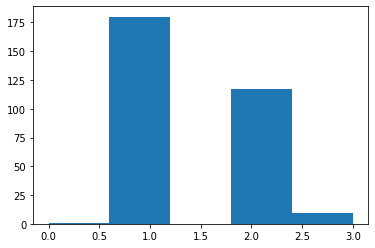

In [22]:
cbbox = np.concatenate(bbox_list, 0)
print(cbbox.shape)
h = plt.hist(cbbox[:, 0], bins=len(class_names))

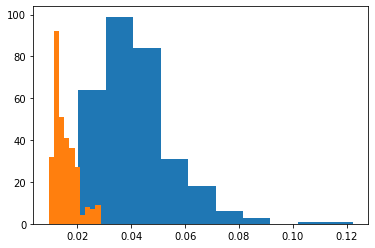

In [23]:
box_w = cbbox[:, -2] - cbbox[:, -4]
box_h = cbbox[:, -1] - cbbox[:, -3]
h = plt.hist(box_h)
h = plt.hist(box_w)

In [24]:
cbbox.shape

(307, 5)

In [25]:
def crop_bbox_image(image, boxes):
    img_objects = []
    image = np.array(image)
    for box in boxes:        
        box = box.astype(np.int)
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1        
        crop_image_arr = image[y1:y2, x1:x2]
        ch, cw, cc = crop_image_arr.shape
        if ch>1 and cw>1:
            img_objects.append(crop_image_arr)
        else:
            print('crop_bbox_image', x2-x1, y2-y1, 'crop_image_arr.shape', crop_image_arr.shape)
        
    return img_objects
    
    
def attach_crop_image(image, boxes, max_crop=200):
        
    crop_bbox_arr = crop_bbox_image(image, np.array(boxes)[:max_crop])
    bbox_k = len(crop_bbox_arr)
    max_col = 30
    
    if bbox_k > 0:
        img_h, img_w, img_c = image.shape
        object_img_w = img_w//bbox_k        
        resize_h = img_h // 8
        resize_w = img_w // bbox_k  
        resize_w = min(max(resize_w, img_w//max_col), img_w//8)
        
        footer_h = resize_h * (1 + (bbox_k-1)//max_col)
        footer = np.zeros((footer_h, img_w, img_c), np.uint8)
        
        for i in range(min(bbox_k, max_crop)):
            crop_arr = crop_bbox_arr[i]
            crop_img = Image.fromarray(crop_arr)                
            crop_img = crop_img.resize((resize_w, resize_h))
            crop_arr_resized = np.array(crop_img)
            offset_y = (i//max_col) * resize_h
            offset_x = (i%max_col) * resize_w
            footer[offset_y:offset_y+resize_h, offset_x:offset_x+resize_w] = crop_arr_resized

        seperate_line = np.zeros_like(footer[:2])
        image = np.concatenate((image, seperate_line, footer), axis=0)    
    return image    

In [26]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)    
    
    img_h, img_w, img_c = image.shape
    
    image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        color = edgecolors[int(cls)]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 70:
            score_txt = class_names[int(cls)]
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [27]:
def tile_object(X, BBOX, scope=0.5):
    
    crop_xs = []
    crop_bboxs = []
    for i in range(len(X)):
        x = X[i]
        img_h, img_w, img_c = x.shape
        bbox = BBOX[i]
        #print('len', len(x), len(bbox), x.shape, bbox.shape)
        cls = bbox[:, 0]
        x0 = bbox[:, 1]
        y0 = bbox[:, 2]
        x1 = bbox[:, 3]
        y1 = bbox[:, 4]
        box_h = y1 - y0
        box_w = x1 - x0
        box_y_min = np.min(y0)
        box_x_min = np.min(x0)        
        box_y_max = np.max(y1)
        box_x_max = np.max(x1)        
        if box_y_max - box_y_min < scope and box_x_max - box_x_min < scope:
            cy = np.mean((box_y_min + box_y_max)/2)
            cx = np.mean((box_x_min + box_x_max)/2)
            if cy < scope:
                ty0 = np.maximum(0, cy - scope/2)
                ty1 = ty0 + scope
            else:
                ty1 = np.minimum(1.0, cy + scope/2)
                ty0 = ty1 - scope
            if cx < 0.5:
                tx0 = np.maximum(0, cx - scope/2)
                tx1 = tx0 + scope
            else:
                tx1 = np.minimum(1.0, cx + scope/2)
                tx0 = tx1 - scope
                        
            tbox = np.stack((cls, (x0 - tx0)/scope, (y0 - ty0)/scope, (x1 - tx0)/scope, (y1 - ty0)/scope), axis=1)
            img_y0 = int(ty0 * img_h)
            img_y1 = img_y0 + int(img_h*scope)
            img_x0 = int(tx0 * img_w)
            img_x1 = img_x0 + int(img_w*scope)
            timg = x[img_y0:img_y1, img_x0:img_x1]
            
            img = Image.fromarray(timg)
            img_resized = img.resize((padded_image_shape[1]//2, padded_image_shape[0]//2 ))
            arr_resized = np.array(img_resized)            
            
            crop_xs.append(arr_resized)
            crop_bboxs.append(tbox)
    return crop_xs, crop_bboxs


In [28]:
def attach_tiled_data(X, BBOX, row=2, col=2):
    m = len(X)
    attach_m = int(np.ceil(m/(row*col)))
    attach_xs = []
    attach_bboxs = []
    img_h, img_w, img_c = X[0].shape
    for i in range(attach_m):
        bg_color = np.median(X[i])
        attach_xs.append(bg_color + np.zeros((img_h*row, img_w*col, img_c)))    
        attach_bboxs.append([])
    
    m_rand = np.arange(m)
    np.random.shuffle(m_rand)
    for i in range(len(m_rand)):
        j = m_rand[i]
        x = X[j]
        bbox = BBOX[j]        
        img_h, img_w, img_c = x.shape
        ti = i//(row*col)
        ty = i%(row*col)//col
        tx = i%(row*col)%col
        dst_y0 = ty * img_h
        dst_y1 = dst_y0 + img_h
        dst_x0 = tx * img_w
        dst_x1 = dst_x0 + img_w
               
        attach_xs[ti][dst_y0:dst_y1, dst_x0:dst_x1] = x                    
        cls, x0, y0, x1, y1 = np.split(bbox, 5, -1)
        
        x_scale = 1.0 / col
        y_scale = 1.0 / row
        x0 = x0 * x_scale + tx * x_scale
        y0 = y0 * y_scale + ty * y_scale
        x1 = x1 * x_scale + tx * x_scale
        y1 = y1 * y_scale + ty * y_scale
        bbox = np.concatenate((cls, x0, y0, x1, y1), axis=1)        
        attach_bboxs[ti].extend(bbox)
            
    for i in range(len(attach_bboxs)):
        attach_bboxs[i] = np.stack(attach_bboxs[i], 0)
        
    return attach_xs, attach_bboxs

In [29]:
def box_convert_cxy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate(( (y0+y1)/2, (x0+x1)/2 ), axis=1)

def box_swap_xy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate((x0, y0, x1, y1), axis=1)

def box_convert_to_xywh(boxes):
    return np.concatenate(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]], axis=-1,)

def box_convert_to_corners(boxes):    
    return np.concatenate(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1,)

def angle_to_radian(angle):
    return angle * np.pi/180

def rotate_images(X, angle):
    rotate_X = []
    for i in range(len(X)):        
        x = X[i]
        img_h = x.shape[0]
        img_w = x.shape[1]
        img = Image.fromarray(x)                
        img_rotated = img.rotate(angle)
        rotate_X.append(np.array(img_rotated))

    return rotate_X
    
def gen_rotate_data(X, BBOX, angle):
    rotate_xs = []
    rotate_bboxs = []
    m = len(X)
    for i in range(m):        
        x = X[i]
        
        bbox = BBOX[i]
        cls = bbox[:, 0]
        x0 = bbox[:, 1]
        y0 = bbox[:, 2]
        x1 = bbox[:, 3]
        y1 = bbox[:, 4]
        
        box = bbox[:, 1:]
        box_xywh = box_convert_to_xywh(box)
        box_xy = box_xywh[:, :2] 
        box_wh = box_xywh[:, 2:] 
        box_uv = (np.reshape(box_xy, [-1, 2]) - 0.5) * 2
        
        img_h, img_w, img_c = x.shape
        img = Image.fromarray(x)        
        scale_mat = np.array([1, 0, 0, 1.0*img_h/img_w]).reshape((2,2))
        scale_mat_rev = np.array([1, 0, 0, 1.0*img_w/img_h]).reshape((2,2))
        
        radian = angle_to_radian(angle)        
        rotate_mat = np.array([np.cos(radian), -np.sin(radian), np.sin(radian), np.cos(radian)])        
        rotate_mat = np.reshape(rotate_mat, (2, 2))
        box_uv_trans = np.matmul(box_uv, scale_mat)
        box_uv_trans = np.matmul(box_uv_trans, rotate_mat)
        box_uv_trans = np.matmul(box_uv_trans, scale_mat_rev)
        box_trans = (box_uv_trans + 1)/2
        box_trans_xy = np.reshape(box_trans, [-1, 2])
        box_trans_xywh = np.concatenate((box_trans_xy, box_wh), axis=1)
        box_trans = box_convert_to_corners(box_trans_xywh)
   
        #if np.min(box_trans)<0 or np.max(box_trans)>1: continue
        
        bbox_trans = np.concatenate((np.expand_dims(cls, 1), box_trans), axis=1)
   
        img_rotated = img.rotate(angle)
        #plt.imshow(img_rotated)
        rotate_xs.append(np.array(img_rotated))
        rotate_bboxs.append(bbox_trans)

    return rotate_xs, rotate_bboxs        

In [30]:
def crop_obj(X, Y):
    crop_obj_list = []
    shape_list = []
    cls_list = []
    for i in range(len(X)):        
        x = X[i]        
        bboxs = Y[i]
        img_h, img_w, img_c = x.shape
        for j in range(len(bboxs)):
            box = bboxs[j]
            #print('box', box)
            cls, x0, y0, x1, y1 = list(box)
            x0 = int(x0 * img_w)
            x1 = int(x1 * img_w)            
            y0 = int(y0 * img_h)
            y1 = int(y1 * img_h)
            
            x_crop = x[y0:y1, x0:x1]
            if np.min(x_crop.shape)<3:
                continue
            crop_obj_list.append(x_crop)
            cls_list.append(cls)
            shape_list.append((x1-x0, y1-y0))
        
    return crop_obj_list, cls_list, shape_list

def attach_obj(crop_obj_list, cls_list, resize_w=32, resize_h=48):
    m = len(crop_obj_list)    
    img_h = padded_image_shape[0]
    img_w = padded_image_shape[1]
    row = img_h//resize_h
    col = img_w//resize_w
    img_m = (m - 1) // (row * col) + 1
    canvas = np.zeros((img_m, img_h, img_w, 3), dtype=np.uint8)
    cbbox_list = []
    for i in range(img_m):
        cbbox_list.append([])
    print('canvas', canvas.shape, row, col)
    cls_sort_index = np.argsort(cls_list)
    for j in range(m):
        i = cls_sort_index[j]
        x = crop_obj_list[i]
        cls = cls_list[i]
        #print(i, x.shape)
        arr = x.astype(np.uint8)
        img = Image.fromarray(arr)
        img = img.resize((resize_w, resize_h))
        x = np.array(img)
        tm = i // (row * col)
        ty = (i % (row * col) )// col
        tx = i % col
        #print(i, tm, ty, tx)
        x0 = tx*resize_w
        x1 = (tx+1)*resize_w
        y0 = ty*resize_h
        y1 = (ty+1)*resize_h
        canvas[tm, y0:y1, x0:x1] = x
        
        cbbox_list[tm].append(np.array([cls, 1.0*x0/img_w, 1.0*y0/img_h, 1.0*x1/img_w, 1.0*y1/img_h]))
        
    for i in range(img_m):
        cbboxs = cbbox_list[i]
        cbbox_list[i] = np.stack(cbboxs, axis=0)
    return canvas, cbbox_list


In [31]:
m = len(input_list)
print('m', m)
input_list_train = input_list[::2]
input_list_test = input_list[1::2]
bbox_list_train = bbox_list[::2]
bbox_list_test = bbox_list[1::2]
print('bbox_list_train', len(bbox_list), len(bbox_list_train), len(bbox_list_test))

m 100
bbox_list_train 100 50 50


mask_cbbox_0 [3.         0.02864583 0.02777778 0.0421875  0.06388889] [3.         0.02211764 0.04955363 0.03565931 0.08566474]


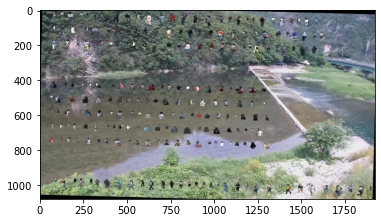

In [32]:
#water_with_ped, water_mask, mask_cbbox
water_with_ped_0, mask_cbbox_0 = gen_rotate_data(water_with_ped, mask_cbbox, angle=1.5)
water_mask_0 = rotate_images(water_mask, angle=1.5)
water_with_ped_1, mask_cbbox_1 = gen_rotate_data(water_with_ped, mask_cbbox, angle=-1.5)
water_mask_1 = rotate_images(water_mask, angle=-1.5)
print('mask_cbbox_0', mask_cbbox[0][0], mask_cbbox_0[0][0])
plt.imshow(water_with_ped_1[0])

In [33]:
water_with_ped = np.concatenate((water_with_ped_0, water_with_ped_1, water_with_ped), 0)
water_mask = np.concatenate((water_mask_0, water_mask_1, water_mask), 0)
mask_cbbox = np.concatenate((mask_cbbox_0, mask_cbbox_1, mask_cbbox), 0)
print('shape', water_with_ped.shape, water_mask.shape, mask_cbbox.shape )

shape (3, 1080, 1920, 3) (3, 1080, 1920) (3, 231, 5)


In [34]:
img_objects, cls_list, shape_list = crop_obj(input_list_train, bbox_list_train)
print('len(img_objects)', len(img_objects), len(cls_list), img_objects[0].dtype)
print('shape_list', np.mean(np.stack(shape_list, 0), 0))

len(img_objects) 154 154 uint8
shape_list [29.7987013 46.3961039]


In [35]:
img_0 = rotate_images(img_objects, angle=1)
img_1 = rotate_images(img_objects, angle=-1)
img_2 = rotate_images(img_objects, angle=2)
img_3 = rotate_images(img_objects, angle=-2)
img_4 = rotate_images(img_objects, angle=3)
img_5 = rotate_images(img_objects, angle=-3)

img_objects = np.concatenate((img_objects, img_0, img_1, img_2, img_3, img_4, img_5), 0)
cls_list_original = cls_list.copy()
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
print(len(img_objects), len(cls_list))

1078 1078


In [36]:
attach_obj_img, attach_obj_bbox = attach_obj(img_objects, cls_list)
print('attach_obj_img', attach_obj_img.shape, len(attach_obj_bbox), len(attach_obj_bbox[0]))

canvas (1, 1024, 1920, 3) 21 60
attach_obj_img (1, 1024, 1920, 3) 1 1078


In [37]:
crop_xs, crop_bboxs = tile_object(input_list_train, bbox_list_train)
print('crop_xs', len(crop_xs), len(crop_bboxs), crop_xs[0].shape, crop_bboxs[0])
#display_data(crop_xs, crop_bboxs, stride=100)

crop_xs 47 47 (512, 960, 3) [[2.         0.52916667 0.76666667 0.56354167 0.84074074]
 [1.         0.803125   0.56666667 0.83333333 0.65740741]
 [1.         0.559375   0.25925926 0.58854167 0.34074074]
 [1.         0.390625   0.15925926 0.4125     0.22777778]
 [1.         0.40833333 0.16111111 0.43125    0.21851852]]


In [38]:
rotate_xs, rotate_bboxs = gen_rotate_data(crop_xs, crop_bboxs, angle=1.5)
rotate_xs_1, rotate_bboxs_1 = gen_rotate_data(crop_xs, crop_bboxs, angle=-1.5)

print('rotate_xs', len(rotate_xs), len(rotate_bboxs))
rotate_xs.extend(rotate_xs_1)
rotate_bboxs.extend(rotate_bboxs_1)

print('crop_xs', len(crop_xs), len(rotate_xs))

rotate_xs 47 47
crop_xs 47 94


rotate_xs_2, rotate_bboxs_2 = gen_rotate_data(crop_xs, crop_bboxs, angle=2.5)
rotate_xs_3, rotate_bboxs_3 = gen_rotate_data(crop_xs, crop_bboxs, angle=-2.5)
rotate_xs.extend(rotate_xs_2)
rotate_bboxs.extend(rotate_bboxs_2)
rotate_xs.extend(rotate_xs_3)
rotate_bboxs.extend(rotate_bboxs_3)

In [39]:
print('crop_xs', len(crop_xs), len(rotate_xs))

crop_xs 47 94


In [40]:
crop_xs = rotate_xs
crop_bboxs = rotate_bboxs

In [41]:
if use_weather_effect:
    weather_k = len(weather_images)
    print('weather_k', weather_k)
    m = len(crop_xs)
    for i in range(m):
        if np.random.rand() < 0.2:
            crop_x = crop_xs[i]
            h, w, c = crop_x.shape            
            weather_image = weather_images[np.random.randint(weather_k)]            
            crop_xs[i] = (crop_x // 3) * 2 + np.array(weather_image.resize((w, h)))//3

In [42]:
attach_xs, attach_bboxs = attach_tiled_data(crop_xs, crop_bboxs, row=2, col=2)
print('attach_xs', len(attach_xs), len(attach_bboxs))

attach_xs 24 24


input_list_train = attach_xs
bbox_list_train = attach_bboxs

display_data(rotate_xs_, rotate_bboxs_, stride=10)

0 [1. 2.]


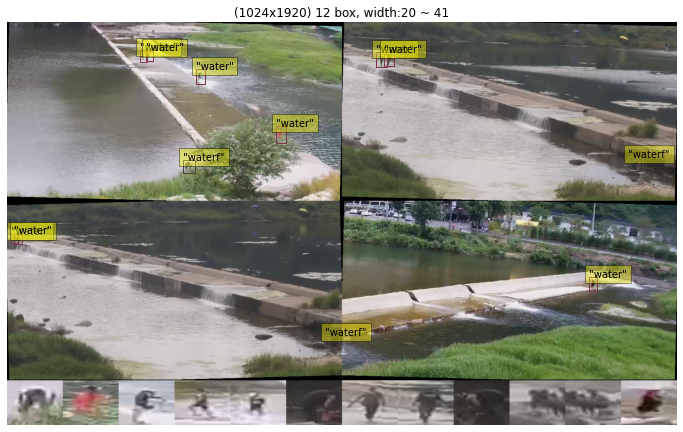

In [43]:
display_data(attach_xs, attach_bboxs, stride=500)

display_data(crop_xs, crop_bboxs, stride=10)

0 [1. 2.]


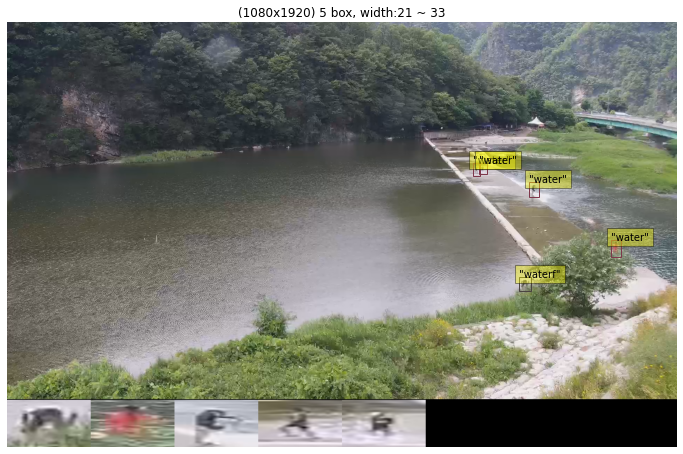

In [44]:
display_data(input_list, bbox_list, stride=500)

In [45]:
print('len', len(input_list_train), len(crop_xs), len(attach_xs))

len 50 94 24


In [46]:
use_zoom_up_data

False

In [47]:
stride = len(input_list_train) // len(attach_xs)
stride = max(1, stride)
for i in range(len(attach_xs)):
    input_list_train.insert(i*stride, attach_xs.pop())
    bbox_list_train.insert(i*stride, attach_bboxs.pop())
if use_zoom_up_data:
    for i in range(len(crop_xs)):
        input_list_train.insert(1+i*stride, crop_xs.pop())
        bbox_list_train.insert(1+i*stride, crop_bboxs.pop())
print('len', len(input_list_train), len(crop_xs), len(attach_xs))

len 74 94 0


stride = len(input_list_train) // len(attach_obj_img)
for i in range(len(attach_obj_img)):    
    input_list_train.insert(i*stride, attach_obj_img[i])
    bbox_list_train.insert(i*stride, attach_obj_bbox[i])

print('len', len(input_list_train), len(attach_obj_img))

input_list_train.extend(list_visdrone_image_arr)
input_list_test.extend(list_visdrone_image_arr)
bbox_list_train.extend(list_visdrone_cbbox)
bbox_list_test.extend(list_visdrone_cbbox)

In [48]:
print('len', len(input_list_train), len(input_list_test))

len 74 50


0 [1. 2.]


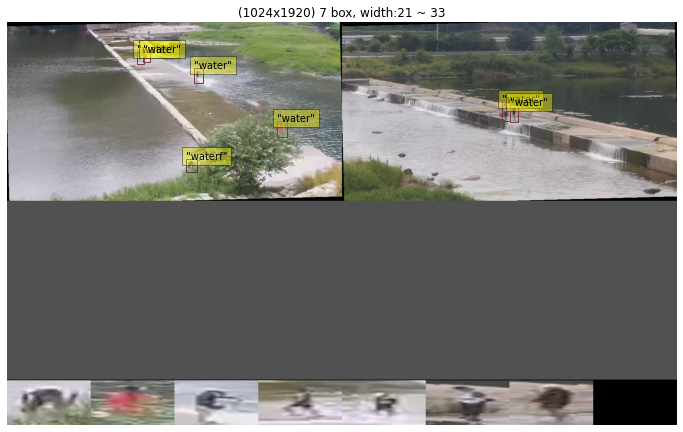

In [49]:
display_data(input_list_train, bbox_list_train, stride=98)

In [50]:
torch.__version__

'1.6.0+cu101'

In [51]:
import os
import re
import zipfile
import numpy as np
import matplotlib.pyplot as plt

def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.
    Returns:
      swapped boxes with shape same as that of boxes.
    """    
    return torch.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return torch.cat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    b0, b1 = torch.split(boxes, 2, -1)
    return torch.cat([b0 - b1 / 2.0, b0 + b1 / 2.0], axis=-1)
    #return torch.cat([boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1,)


"""
## Computing pairwise Intersection Over Union (IOU)
As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.
"""

def compute_iou(boxes1, boxes2):#compute_iou(anchor_boxes, gt_boxes)
    """Computes pairwise IOU matrix for given two sets of boxes
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    if is_debug:
        print('boxes1', boxes1.shape)
        print('boxes2', boxes2.shape)
    boxes1_corners = convert_to_corners(boxes1)#(None, 4)
    boxes2_corners = convert_to_corners(boxes2)
        
    #boxes1_corners_ex = torch.unsqueeze(boxes1_corners, 1)
    #boxes2_corners_ex = torch.unsqueeze(boxes2_corners, 1)
    #print('boxes1_corners_ex', boxes1_corners_ex.shape)
    
    lu = torch.max(boxes1_corners[:, None, :2], boxes2_corners[:, :2])#(None, None, 2)
    rd = torch.min(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    #torch.clamp_max(rd - lu, )
    
    intersection = torch.max(torch.zeros_like(rd), rd - lu)
    if is_debug: print('intersection', intersection.shape)#[389205, 5, 2]
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    #boxes1_area = torch.unsqueeze(boxes1_area, 1)
    union_area = boxes1_area[:, None] + boxes2_area - intersection_area
    union_area = torch.max(union_area, torch.zeros_like(union_area) + 1e-8)
    
    return torch.clamp(intersection_area / union_area, 0.0, 1.0)

In [52]:

"""
## Implementing Anchor generator
Anchor boxes are fixed sized boxes that the model uses to predict the bounding
box for an object. It does this by regressing the offset between the location
of the object's center and the center of an anchor box, and then uses the width
and height of the anchor box to predict a relative scale of the object. In the
case of RetinaNet, each location on a given feature map has nine anchor boxes
(at three scales and three ratios).
"""
class AnchorBox:
    """Generates anchor boxes.
    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.
    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.level_start = level_start
        self.level_end = level_end
        
        if anchor_k==9:
            self.aspect_ratios = [0.5, 1.0, 2.0]        
            self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        else:
            self.aspect_ratios = [1.0]        
            self.scales = [2 ** x for x in [0]]
                
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(self.level_start, self.level_end)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 196.0, 256.0]]                        
        
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = np.sqrt(area / ratio)
                anchor_width = area / anchor_height
                
                anchor_wh = np.stack([anchor_width, anchor_height], axis=-1)
                dims = np.reshape(anchor_wh, [1, 1, 2])
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(np.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level
        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.
        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = np.arange(feature_width, dtype=np.float) + 0.5
        ry = np.arange(feature_height, dtype=np.float) + 0.5
        centers = np.stack(np.meshgrid(rx, ry), axis=-1) * self._strides[level - self.level_start]
        centers = np.expand_dims(centers, axis=-2)
        
        centers = np.tile(centers, [1, 1, self._num_anchors, 1])        
        #centers = centers.repeat([1, 1, self._num_anchors, 1])
        dims = np.tile(self._anchor_dims[level - self.level_start], [feature_height, feature_width, 1, 1])
        #dims = self._anchor_dims[level - self.level_start].repeat([feature_height, feature_width, 1, 1])
        anchors = np.concatenate([centers, dims], axis=-1)
        return np.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                int(np.ceil(image_height / 2 ** i)),
                int(np.ceil(image_width / 2 ** i)),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return np.concatenate(anchors, axis=0)
    
    def get_anchors_check(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """        
        anchors = [
            self._get_anchors(
                int(np.ceil(image_height / 2 ** i)),
                int(np.ceil(image_width / 2 ** i)),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return anchors

In [53]:
level_start, level_end

(3, 8)

In [54]:
anchor_check = AnchorBox()

In [55]:
anchors = anchor_check.get_anchors_check(128,128)
for anchor in anchors:
    print(anchor.shape, anchor[-1])

(2304, 4) [124.         124.          71.83757109  35.91878555]
(576, 4) [120.         120.         143.67514218  71.83757109]
(144, 4) [112.         112.         287.35028437 143.67514218]
(36, 4) [ 96.          96.         440.00512294 220.00256147]
(9, 4) [ 64.          64.         574.70056873 287.35028437]


In [56]:
padded_image_shape

(1024, 1920)

In [57]:
anchors = anchor_check.get_anchors_check(padded_image_shape[0], padded_image_shape[1])
anchor_k = 0
for anchor in anchors:
    anchor_k += anchor.shape[0]
    print(anchor.shape, anchor[-1])
print('anchor_k', anchor_k)

(276480, 4) [1916.         1020.           71.83757109   35.91878555]
(69120, 4) [1912.         1016.          143.67514218   71.83757109]
(17280, 4) [1904.         1008.          287.35028437  143.67514218]
(4320, 4) [1888.          992.          440.00512294  220.00256147]
(1080, 4) [1856.          960.          574.70056873  287.35028437]
anchor_k 368280


In [58]:
def preprocess_data(image, bbox):
    
    image = F.interpolate(image, padded_image_shape)    
    
    image_shape = torch.tensor(image.shape[-2:], dtype=torch.float32)
    padded_image_shape_f = torch.tensor(padded_image_shape, dtype=torch.float32)
    pad_ratio = image_shape / padded_image_shape_f
    
    margin = 1
    bbox_padded = torch.stack(
        [            
            bbox[:, 1] * image_shape[1]-margin,
            bbox[:, 2] * image_shape[0]-margin,
            bbox[:, 3] * image_shape[1]+margin,
            bbox[:, 4] * image_shape[0]+margin            
        ],
        axis=-1,
    )
    cls = bbox[:, 0:1]
    #print('preprocess_data(bbox_padded)', bbox_padded.shape)
    bbox_padded = convert_to_xywh(bbox_padded)
    cbbox = torch.cat((bbox_padded, cls), -1)
    return image, cbbox


def preprocess_test_data(image, cls_bbox, mask_obj):         
    bbox = cls_bbox[:, 1:]
    class_id = torch.cast(cls_bbox[:, 0], dtype=torch.int32)        
    
    image, image_shape, _, mask_obj = resize_and_pad_image(image, mask_obj)
    
    bbox = torch.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)    
    return image, bbox, class_id, mask_obj


def image_color_augment(x):
    if tf.random.uniform(()) < -0.5:
        x_max = tf.reduce_max(x, [1, 2], True)
        x = x_max - x
    if tf.random.uniform(()) < -0.2:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((b, g, r), -1)
    elif tf.random.uniform(()) < -0.4:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((b, r, g), -1)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
    if tf.random.uniform(()) < -0.2:
        gray = tf.image.rgb_to_grayscale(x)
        x = tf.concat((gray, gray, gray), -1)        
    if tf.random.uniform(()) < -0.2:
        noise = tf.random.normal(tf.shape(x), stddev=tf.pow(tf.reduce_mean(x), 0.3))
        x += noise
    if tf.random.uniform(()) < 0.2:
        x = gaussian_filter2d(x, filter_shape=tuple(np.random.randint(1, 10, (2))), sigma=10)
        #x = gaussian_filter2d(x, filter_shape=np.random.randint(3, 10, (2)), sigma=10)
    if tf.random.uniform(()) < 0.2:        
        x = sharpness(x, factor=10)    
            
    #x = tf.image.random_jpeg_quality(x, 0, 1.0)
    #x = tf.clip_by_value(x, 0, 1)
    
    return x

In [59]:
"""
## Encoding labels
The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:
- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes
"""

class LabelEncoder:
    """Transforms the raw labels into targets for training.
    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.
    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        
        self._box_variance = torch.tensor([0.1, 0.1, 0.2, 0.2], dtype=torch.float32)    
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        if is_debug:
            print('_compute_box_target(anchor_boxes)', anchor_boxes.shape)
            print('_compute_box_target(matched_gt_boxes)', matched_gt_boxes.shape)
        box_target = torch.cat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                torch.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.2
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)#([389205, 5])
        
        max_iou, idx = torch.max(iou_matrix, axis=1)#from anchor to object-box        
        matched_gt_idx = torch.argmax(iou_matrix, axis=1) #389205
        positive_mask = torch.ge(max_iou, match_iou)# not only this, but also need max iou cell
        
        positive_proposal_mask = torch.ge(iou_matrix, match_iou)
        positive_mask = torch.any(positive_proposal_mask, axis=1)
        
        negative_mask = max_iou < ignore_iou
        
        max_iou_anchor, idx = torch.max(iou_matrix, axis=0, keepdim=True) 
        if is_debug:
            print('iou_matrix', iou_matrix.shape)
            print('max_iou_anchor', max_iou_anchor.shape)
        max_iou_anchor_mask = torch.ge(iou_matrix, max_iou_anchor)
        positive_max_mask = torch.any(max_iou_anchor_mask, axis=1)
        positive_mask = torch.logical_or(positive_mask, positive_max_mask)#new      
        
        negative_mask = torch.logical_and(negative_mask, torch.logical_not(positive_mask))
        ignore_mask = torch.logical_not(torch.logical_or(positive_mask, negative_mask))        
        
        return (
            matched_gt_idx,            
            positive_mask.float(),
            positive_max_mask.float(),            
            ignore_mask.float(),
        )

    def _encode_sample(self, image_shape, gt):
        """Creates box and classification targets for a single sample"""
        
        gt_boxes = gt[:, :4]
        cls_ids = gt[:, 4]
        
        if is_debug: print('_encode_sample_image_shape', image_shape)
        anchor_boxes = self._anchor_box.get_anchors(padded_image_shape[0], padded_image_shape[1])
        anchor_boxes = torch.tensor(anchor_boxes)
        cls_ids = cls_ids.float()
        matched_gt_idx, positive_mask, positive_max_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        if is_debug:
            print('gather_problem')
            print('gt_boxes', gt_boxes.shape)
            print('matched_gt_idx', matched_gt_idx.shape)
        #matched_gt_idx_exp = torch.unsqueeze(matched_gt_idx, 1)
        #matched_gt_boxes = torch.gather(gt_boxes, 0, matched_gt_idx_exp)#?
        matched_gt_boxes = gt_boxes[matched_gt_idx]
       
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)    
        #matched_gt_cls_ids = torch.gather(cls_ids, 0, matched_gt_idx)#??
        matched_gt_cls_ids = cls_ids[matched_gt_idx]
        if is_debug: print('matched_gt_cls_ids', matched_gt_cls_ids.shape)
        zero_mask = torch.zeros_like(positive_mask)
        cls_target = torch.where(
            torch.logical_not(torch.eq(positive_mask, zero_mask+1.0)), zero_mask, matched_gt_cls_ids
        )
        cls_target = torch.where(torch.eq(ignore_mask, zero_mask+1.0), zero_mask-1.0, cls_target)       
        cls_target = torch.unsqueeze(cls_target, axis=-1)        
        label = torch.cat([box_target, cls_target], axis=-1)        
        return label
    
    def encode_batch(self, batch_images, label):
        """Creates box and classification targets for a batch"""
        #is_flipped 0 or 1
        images_shape = batch_images.shape
        batch_size = images_shape[0]
        
        batch_images, gt = preprocess_data(batch_images, label)
       
        labels = []
        #for i in range(batch_size):
        labels = self._encode_sample(images_shape, gt)
        #labels.append(label)
        
        #labels = torch.stack(labels, 0)
        batch_images = batch_images.float()
        label = torch.reshape(labels, [1, -1, 5])                
        return batch_images, label
      
    
    def encode_batch_train(self, batch_images, gt_boxes, cls, mask_obj):
        """Creates box and classification targets for a batch"""
        
        #batch_images = image_color_augment(batch_images)#new        
        return self.encode_batch(batch_images, gt_boxes, cls, mask_obj)

In [60]:
def normalize_image(x):
    x_max, idx = torch.max(x, -1, keepdim=True)
    x_min, idx = torch.min(x, -1, keepdim=True)
    
    x_max, idx = torch.max(x_max, -2, keepdim=True)
    x_min, idx = torch.min(x_min, -2, keepdim=True)
        
    return (x - x_min) / (x_max - x_min)

In [61]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        channels = 64
        channels_pyramid = 256        
        self.conv1 = nn.Conv2d(3, channels, kernel_size=7, stride=2, padding=3)
        #self.pool = nn.MaxPool2d(2, 2)
        #_blocks_list = [2, 2, 2, 2]#resnet-18
        #num_blocks_list = [3, 4, 6, 3]#resnet-34
        
        self.layer1_iden = nn.Conv2d(channels, channels, kernel_size=1, stride=2, padding=0)
        self.layer2_iden = nn.Conv2d(channels, channels * 2, kernel_size=1, stride=2, padding=0)
        self.layer3_iden = nn.Conv2d(channels * 2, channels * 4, kernel_size=1, stride=2, padding=0)
        self.layer4_iden = nn.Conv2d(channels * 4, channels * 8, kernel_size=1, stride=2, padding=0)
        
        self.layer10 = self._residual_block(channels, channels, downsample=True)
        self.layer11 = self._residual_block(channels, channels)
        self.layer12 = self._residual_block(channels, channels)
        
        self.layer20 = self._residual_block(channels, channels * 2, downsample=True)
        self.layer21 = self._residual_block(channels * 2, channels * 2)
        self.layer22 = self._residual_block(channels * 2, channels * 2)
        self.layer23 = self._residual_block(channels * 2, channels * 2)
        
        self.layer30 = self._residual_block(channels * 2, channels * 4, downsample=True)
        self.layer31 = self._residual_block(channels * 4, channels * 4)
        
        self.layer40 = self._residual_block(channels * 4, channels * 8, downsample=True)
        self.layer41 = self._residual_block(channels * 8, channels * 8)
        
        self.conv3 = nn.Conv2d(channels * 2, channels_pyramid, kernel_size=1)
        self.conv4 = nn.Conv2d(channels * 4, channels_pyramid, kernel_size=1)
        self.conv5 = nn.Conv2d(channels * 8, channels_pyramid, kernel_size=1)
        self.upsampling = nn.UpsamplingNearest2d(scale_factor=2)
        self.upsampling1 = nn.UpsamplingNearest2d(scale_factor=2)
        
        self.conv33 = nn.Conv2d(channels_pyramid, channels_pyramid, kernel_size=3, padding=1)
        self.conv44 = nn.Conv2d(channels_pyramid, channels_pyramid, kernel_size=3, padding=1)
        self.conv55 = nn.Conv2d(channels_pyramid, channels_pyramid, kernel_size=3, padding=1)
        self.conv56 = nn.Conv2d(channels_pyramid, channels_pyramid, kernel_size=3, stride=2, padding=1)
        self.conv67 = nn.Conv2d(channels_pyramid, channels_pyramid, kernel_size=3, stride=2, padding=1)
        
        self.head_cls = self._head(channels_pyramid, num_classes)
        self.head_reg = self._head(channels_pyramid, 4)
       
                
    
    def _residual_block(self, in_channels, out_channels, downsample=False):
        
        layers = []
        stride = (1 if not downsample else 2)
       
        conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        layers.append(conv1)
        layers.append(nn.ReLU())
        layers.append(conv2)        
      
        return nn.Sequential(*layers)
    
    
    def _head(self, in_channels, out_channels):
        layers = []
        for i in range(4):
            layers.append(nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        return nn.Sequential(*layers)        
    
    
    def forward(self, x):
        x = normalize_image(x)
        net_lv0 = F.relu(self.conv1(x))
        
        net_lv1_i = self.layer1_iden(net_lv0)        
        net_lv1 = F.relu(self.layer10(net_lv0) + net_lv1_i)
        net_lv1 = F.relu(self.layer11(net_lv1) + net_lv1)
        net_lv1 = F.relu(self.layer12(net_lv1) + net_lv1)
        
        net_lv2_i = self.layer2_iden(net_lv1)        
        net_lv2 = F.relu(self.layer20(net_lv1) + net_lv2_i)
        net_lv2 = F.relu(self.layer21(net_lv2) + net_lv2)
        net_lv2 = F.relu(self.layer22(net_lv2) + net_lv2)
        net_lv2 = F.relu(self.layer23(net_lv2) + net_lv2)
        
        net_lv3_i = self.layer3_iden(net_lv2)        
        net_lv3 = F.relu(self.layer30(net_lv2) + net_lv3_i)
        net_lv3 = F.relu(self.layer31(net_lv3) + net_lv3)
        
        net_lv4_i = self.layer4_iden(net_lv3)        
        net_lv4 = F.relu(self.layer40(net_lv3) + net_lv4_i)
        net_lv4 = F.relu(self.layer41(net_lv4) + net_lv4)
                
        p3_output = self.conv3(net_lv2)
        p4_output = self.conv4(net_lv3)
        p5_output = self.conv5(net_lv4)
        p5_output_up = self.upsampling(p5_output)
        p4_output_up = self.upsampling1(p4_output)
        p4_output = p4_output + p5_output_up        
        
        p3_output = p3_output + p4_output_up#height 135, 136

        p3_output = self.conv33(p3_output)
        p4_output = self.conv44(p4_output)
        p5_output = self.conv55(p5_output)
        p6_output = self.conv56(p5_output)
        p7_output = self.conv67(p6_output)
      
        features = [p3_output, p4_output, p5_output, p6_output, p7_output]
        
        cbox_outputs = []        
        N = 1
        
        for feature in features:            
        
            cls_out = self.head_cls(feature)
            box_out = self.head_reg(feature)

            cls_out = torch.reshape(cls_out, [N, -1, num_classes])
            box_out = torch.reshape(box_out, [N, -1, 4])        
            
            obj = cls_out[:, :, :1]
            cls = cls_out[:, :, 1:1+num_classes_real]
            other = cls_out[:, :, 1+num_classes_real:]
            
            obj_prob = F.sigmoid(obj)            
            cls_prob = F.softmax(cls, -1)

            cbox_out = torch.cat((box_out, obj_prob, cls_prob, other), axis=-1)#new        
            cbox_outputs.append(cbox_out)        
        
        outputs = torch.cat(cbox_outputs, axis=1)    
        #outputs = torch.reshape(outputs, [N, -1, 4 + num_classes])
        
        return outputs

In [62]:
Net()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (layer1_iden): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
  (layer2_iden): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (layer3_iden): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (layer4_iden): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (layer10): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer11): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer12): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer20): Sequential(
    (0): Conv2d(64, 128, kernel_size

In [63]:
def _decode_box_predictions(anchor_boxes, box_predictions):
    _box_variance = torch.tensor([0.1, 0.1, 0.2, 0.2], dtype=torch.float32)
    
    #if torch.cuda.is_available(): _box_variance = _box_variance.cuda()
    #box_predictions = torch.tensor(box_predictions)
    
    #anchor_boxes = anchor_boxes.cpu()
    #box_predictions = box_predictions.cpu()
    _box_variance = _box_variance.cuda()
    boxes = box_predictions * _box_variance    
    anchor_boxes = torch.tensor(anchor_boxes).cuda()
    boxes = torch.cat(
        [
            boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
            torch.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
        ],
        axis=-1,
    )
    boxes_transformed = convert_to_corners(boxes)
    return boxes_transformed

def decodePredictions(predictions, 
                      num_classes=num_classes,
                      confidence_threshold=0.5,
                      nms_iou_threshold=0.2,
                      max_detections_per_class=1000,
                      max_detections=1500,
                      box_variance=[0.1, 0.1, 0.2, 0.2]):
    
    _anchor_box = AnchorBox()        
    
    image_h = padded_image_shape[0]
    image_w = padded_image_shape[1]
    
    anchor_boxes = _anchor_box.get_anchors(image_h, image_w)
    
    if False and torch.cuda.is_available(): 
        #anchor_boxes = anchor_boxes.cuda()
        anchor_boxes = torch.tensor(anchor_boxes)
        predictions = torch.tensor(predictions)
        
    box_predictions = predictions[:, :, :4]    
    objectness = predictions[:, :, 4:5]
    cls_score = predictions[:, :, 5:5+num_classes_real]    
    cls_prob = cls_score    
    cls = torch.argmax(cls_score, -1)
    cls = cls.float()
    
    boxes = _decode_box_predictions(anchor_boxes[None, ...], box_predictions)
    boxes_2d = torch.reshape(boxes, [-1, 4])    
    scores = torch.reshape(objectness, [-1, 1])#new    
    cls = torch.reshape(cls, [-1, 1])
    ccbox = torch.cat((cls, scores, boxes_2d), -1)
    ccbox_obj = ccbox[scores[:, 0] > 0.5]
    selected_indices = torchvision.ops.nms(ccbox_obj[:, 2:], ccbox_obj[:, 1], nms_iou_threshold)
    
    output = ccbox_obj[selected_indices]
    return output   

In [64]:
torch.tensor([1,2,3.0]).int(), num_classes

(tensor([1, 2, 3], dtype=torch.int32), 80)

In [65]:
torch.nn.functional.one_hot(torch.tensor([1,2,3.0]).to(torch.int64), 4)

tensor([[0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])

In [66]:
#torch.softmax(torch.tensor([1,2,3.0]))
torch.tensor([1,2,3.0]), torch.tensor([1,2,3.0]).to(torch.int64)

(tensor([1., 2., 3.]), tensor([1, 2, 3]))

In [67]:
def classificationLoss(y_cls, y_pred, alpha, gamma):
    if is_debug:
        print('classificationLoss(y_cls)', y_cls.shape)
        print('classificationLoss(y_pred)', y_pred.shape)         
    
    y_positive = (y_cls > 0).float()
    #y_cls_pos = y_cls * (y_cls >= 0).float()
    y_cls_pos = torch.where(y_cls>0, y_cls, torch.zeros_like(y_cls))
    y_hot = torch.nn.functional.one_hot(y_cls_pos.to(torch.int64), num_classes_real)
    is_exist_non_human_class = torch.any(y_cls > 1)
    
    obj_score = y_pred[:, :, 0]#todo
    cls_pt = y_pred[:, :, 1:1+num_classes_real]
    objectness = obj_score + torch.mean(y_pred[:, :, 1:]*0, axis=-1)
   
    pt = torch.clamp(obj_score, 1e-7, 1.0 - 1e-7)

    loss_p = - (1.0 - alpha) * torch.pow(1.0 - pt, gamma) * y_positive * torch.log(pt)        
    loss_f = - alpha * torch.pow(pt, gamma) * (1 - y_positive) * torch.log(1 - pt)
    loss_obj = loss_p + loss_f

    y_hot = y_hot[:, :, :num_classes_real]
    
    zero = torch.zeros_like(cls_pt)
    cls_pt = torch.clamp(cls_pt, 1e-7, 1.0 - 1e-7)
    loss_cls_p = - torch.pow(1.0 - cls_pt, gamma) * y_hot * torch.log(cls_pt)
    loss_cls_f = - torch.pow(cls_pt, gamma) * (1 - y_hot) * torch.log(1 - cls_pt)
    loss_cls = torch.sum(loss_cls_p + loss_cls_f, axis=-1)        

    #FP = (1 - y_positive) * torch.round(pt)
    #FP_max_prob, idx = torch.max((1 - y_positive) * pt, -1, True)
    #FP_train_target = (1 - y_positive) * (pt > FP_max_prob - 0.01).float()
    #loss_cls = (y_positive + FP_train_target) * loss_cls
    loss_cls = y_positive * loss_cls
    #loss = gamma * (loss_obj + loss_cls)
    loss = gamma * loss_obj
    return loss


def retinaNetLoss(y, h):
    
    alpha=0.15
    gamma=2.0
    delta=1.0
        
    y_box = y[:, :, :4]
    y_cls = y[:, :, 4]
    
    h_box = h[:, :, :4]
    h_obj = h[:, :, 4]
    h_cls = h[:, :, 4:-1]        
    
    positive_mask = y_cls > 0.0
    ignore_mask = y_cls < 0.0
        
    box_loss = torch.sum(torch.abs(y_box - h_box), -1)
    clf_loss = classificationLoss(y_cls, h_cls, alpha, gamma)
 
    clf_loss = torch.masked_select(clf_loss, torch.logical_not(ignore_mask))
    box_loss = torch.masked_select(box_loss, positive_mask)
    #clf_loss = torch.where(ignore_mask, torch.zeros_like(clf_loss), clf_loss)        
    #box_loss = torch.where(positive_mask, box_loss, torch.zeros_like(box_loss))    

    #positive_mask_f = positive_mask.float()

    #normalizer = torch.sum(positive_mask_f, axis=-1) + 1        
    clf_loss = 100 * torch.mean(clf_loss, axis=-1)# / normalizer #test
    box_loss = torch.mean(box_loss, axis=-1)# / normalizer
    #clf_loss /= normalizer
    #box_loss /= normalizer
    
    #loss = torch.mean(clf_loss + box_loss)
    return clf_loss, box_loss

In [68]:
def recall(y_true, y_pred):    
    y_cls = (y_true[:, :, 4]).int()
    y_positive = (y_cls > 0).int()
    y_bg = (y_cls == 0).int()
    h_score = y_pred[:, :, 4]
    h_prob = h_score
    h_postive = (torch.round(h_prob)).int()
    
    true_positives = torch.logical_and(y_cls > 0, h_postive>0).float()
    false_negative = y_positive * (1 - h_postive)
                
    tp = torch.sum(true_positives, axis=1)
    fn = torch.sum(false_negative, axis=1)
    tp = (tp).float()
    fn = (fn).float()
    
    rec = tp / (tp + fn + 1e-8)
    rec = torch.mean(rec)
    return rec

def precision(y_true, y_pred):
    
    y_cls_symbol = (y_true[:, :, 4]).int()
    y_cls_symbol = (y_cls_symbol != 0).int()
    h_obj_prob = y_pred[:, :, 4]
    h_cls_symbol = torch.round(h_obj_prob)    
    h_cls_symbol = (h_cls_symbol).int()
        
    true_positives = y_cls_symbol * h_cls_symbol
    false_positive = (1 - y_cls_symbol) * h_cls_symbol
    
    ones = torch.ones_like(true_positives)
    zeeros = torch.zeros_like(true_positives)
    true_positives = torch.eq(true_positives, ones).float()
    false_positive = torch.eq(false_positive, ones).float()
    
    tp = torch.sum(true_positives, axis=1)
    fp = torch.sum(false_positive, axis=1)
    tp = (tp).float()
    fp = (fp).float()
    prec = tp / (tp + fp + 1e-8)
    prec = torch.mean(prec)
    return prec

def accuracy(y_true, y_pred):    
    y_cls = torch.cast(y_true[:, :, 4], torch.int32)
    y_positive = y_cls > 0
    y_bg = torch.cast(y_cls == 0, torch.int32)
    h_score = y_pred[:, :, 4]        
    h_prob = h_score
    h_postive = torch.cast(torch.round(h_prob), torch.int32)
    h_cls = torch.argmax(y_pred[:, :, 5:5+num_classes_real], -1, output_type=tf.torch32)        
    acc = torch.masked_select(torch.equal(y_cls, h_cls), y_positive)    
    return acc


In [69]:
label_encoder = LabelEncoder()
anchor_k = len(label_encoder._anchor_box.aspect_ratios)*len(label_encoder._anchor_box.scales)

In [70]:
np.set_printoptions(precision=3, linewidth=200)
image_height, image_width = padded_image_shape

img_check = 0
inputs = input_list_train[0:1]
labels = bbox_list_train[0]       

inputs = np.stack(inputs, 0)
labels = np.array(labels)

inputs = torch.tensor(inputs)
labels = torch.tensor(labels)

inputs = torch.transpose(inputs, 2, 3)
inputs = torch.transpose(inputs, 1, 2)
inputs = inputs.type(torch.float32)

inputs, cbbox = label_encoder.encode_batch(inputs, labels)
cbbox = np.array(cbbox)
bbox = cbbox[:, :, :4]
cls_gt = cbbox[:,:,4]

print('bbox', bbox.shape)
print('cls_gt', cls_gt.shape)

np.set_printoptions(precision=3, linewidth=200)


print('cls_gt', cls_gt.shape)

img_m, image_ch, image_height, image_width = inputs.shape
print('img_m, image_height, image_width, image_ch', img_m, image_height, image_width, image_ch)
anchor_feature_size = [(np.ceil(image_height / 2 ** i), np.ceil(image_width / 2 ** i)) 
                       for i in range(level_start, level_end)]
print('anchor_feature_size', anchor_feature_size)    
m = len(cbbox)    
positive_count = np.sum(cls_gt>0)
print('cbbox', cbbox.shape)
print('cls_sum',np.sum(cls_gt < 0.0), np.sum(cls_gt == 0.0), 
      np.sum(cls_gt == 1.0), np.sum(cls_gt > 1.0))
print('cls_mean',np.mean(cls_gt < 0.0), np.mean(cls_gt == 0.0), 
      np.mean(cls_gt == 1.0), np.mean(cls_gt > 0.0))
print('shape',cbbox.shape,'unique', np.unique(cls_gt))
print('anchor_feature_size', anchor_feature_size)
offset = 0
positive_maps = []
for anchor_feature_size_1 in anchor_feature_size:        
    fm_h, fm_w = anchor_feature_size_1
    fm_h = int(fm_h)
    fm_w = int(fm_w)        
    fm_wh = int(fm_h * fm_w * anchor_k)
    cbbox_anchor = cbbox[:, offset:offset+fm_wh, 4]
    cbbox_anchor = np.reshape(cbbox_anchor, [m, fm_h, fm_w, anchor_k])
    coount_m1 = np.count_nonzero(cbbox_anchor==-1)
    coount_0 = np.count_nonzero(cbbox_anchor==0)
    coount_1 = np.count_nonzero(cbbox_anchor==1)
    coount_1_over = np.count_nonzero(cbbox_anchor>1)
    positive_ratio = np.mean(cbbox_anchor>0)
    positive_maps.append(cbbox_anchor>0)
    print('cbbox_anchor', cbbox_anchor.shape, coount_m1, coount_0, coount_1, coount_1_over, 'ratio', positive_ratio)
    sample_0_cbbox = cbbox_anchor[0]
    sample_0_cbbox_sum = np.max(sample_0_cbbox, -1).astype(np.int)       

    offset += fm_wh
    if False:            
        file_name = str(fm_h)+ '_' + str(fm_w)+ '.txt'
        np.savetxt(file_name,sample_0_cbbox_sum, fmt='%d',delimiter='')
img_check = np.transpose(inputs, (0,2,3,1) )

bbox (1, 40920, 4)
cls_gt (1, 40920)
cls_gt (1, 40920)
img_m, image_height, image_width, image_ch 1 1024 1920 3
anchor_feature_size [(128.0, 240.0), (64.0, 120.0), (32.0, 60.0), (16.0, 30.0), (8.0, 15.0)]
cbbox (1, 40920, 5)
cls_sum 167 40731 18 4
cls_mean 0.004081133919843597 0.9953812316715542 0.0004398826979472141 0.0005376344086021505
shape (1, 40920, 5) unique [-1.  0.  1.  2.]
anchor_feature_size [(128.0, 240.0), (64.0, 120.0), (32.0, 60.0), (16.0, 30.0), (8.0, 15.0)]
cbbox_anchor (1, 128, 240, 1) 117 30581 18 4 ratio 0.0007161458333333333
cbbox_anchor (1, 64, 120, 1) 50 7630 0 0 ratio 0.0
cbbox_anchor (1, 32, 60, 1) 0 1920 0 0 ratio 0.0
cbbox_anchor (1, 16, 30, 1) 0 480 0 0 ratio 0.0
cbbox_anchor (1, 8, 15, 1) 0 120 0 0 ratio 0.0


In [71]:
img_check.shape

torch.Size([1, 1024, 1920, 3])

Text(0.5, 1.0, '(1, 128, 240, 1)0.0007161458333333333 22')

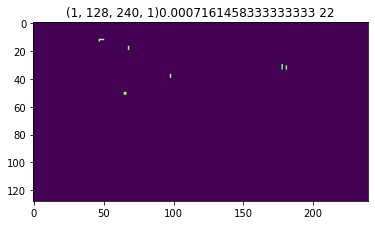

In [72]:
plt.imshow(np.max(positive_maps[0][0], -1))
plt.title(str(positive_maps[0].shape)+ str(np.mean(positive_maps[0][0]))+ ' ' + str(np.sum(positive_maps[0][0])))

In [73]:
pmap0 = np.array(Image.fromarray(np.max(positive_maps[0][0],-1)).resize((image_width, image_height)))
pmap1 = np.array(Image.fromarray(np.max(positive_maps[1][0],-1)).resize((image_width, image_height)))
pmap2 = np.array(Image.fromarray(np.max(positive_maps[2][0],-1)).resize((image_width, image_height)))
pmap3 = np.array(Image.fromarray(np.max(positive_maps[3][0],-1)).resize((image_width, image_height)))
pmap4 = np.array(Image.fromarray(np.max(positive_maps[4][0],-1)).resize((image_width, image_height)))
pmap0 = pmap0.astype(np.uint8)
pmap1 = pmap1.astype(np.uint8)
pmap2 = pmap2.astype(np.uint8)
pmap3 = pmap3.astype(np.uint8)
pmap4 = pmap4.astype(np.uint8)

In [74]:
folder_model = './model/'
path_model = folder_model+'water_state.pt'
if not os.path.isdir(folder_model):
    os.mkdir(folder_model)
#torch.save(model.state_dict(), path_model)

pmap_with_img (1024, 1920, 3)
pmap_add (1024, 1920, 1)


Text(0.5, 1.0, '0.0007161458333333333')

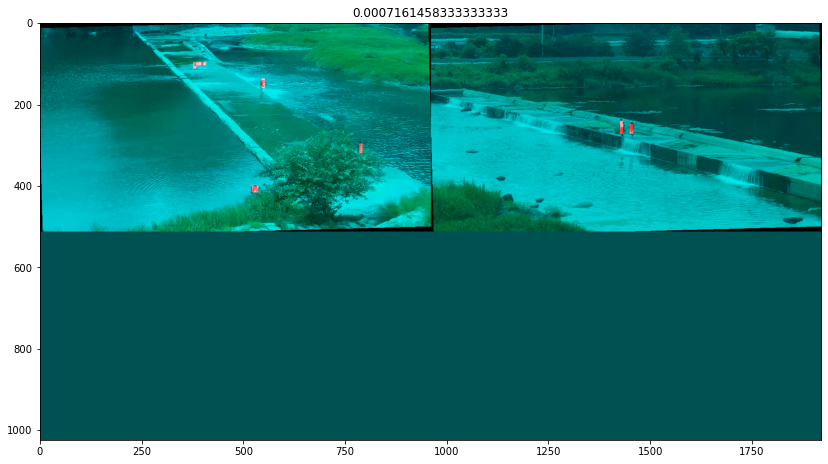

In [75]:
pmap_with_img =  np.array(img_check)[0]#*255
pmap_with_img = pmap_with_img.astype(np.uint8)
pmap_add = np.expand_dims(pmap0+pmap1+pmap2+pmap3+pmap4, -1)
print('pmap_with_img', pmap_with_img.shape)
print('pmap_add', pmap_add.shape)
pmap = (pmap_add>0).astype(np.uint8)*255
mix_rgb = np.concatenate((pmap, pmap_with_img[:,:,1:]),-1)
#mix_rgb = np.concatenate((pmap, pmap, pmap),-1)
plt.figure(figsize=(14,14))
plt.imshow(mix_rgb)
plt.title(str(np.mean(pmap_add)))

In [76]:
def save_model(model):    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, path_model)
    
def load_model(model):    
    checkpoint = torch.load(path_model)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

In [77]:
net = Net()
if torch.cuda.is_available():
    net = net.cuda()
    print('net cuda')

net cuda


In [78]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, momentum=0.5)

In [79]:
len(input_list_train), len(input_list_test)

(74, 50)

In [83]:
load_model(net)

In [84]:
#.fit
m_train = len(input_list_train)
batch_size = 1
for epoch in range(10000):
    running_loss = 0.0
    iter_times = []
    #for i in range(m_train//batch_size):
    for i in range(1):
        start_time = time.time()
        s = i * batch_size
        e = s + batch_size
        inputs = input_list_train[s:e]
        labels = bbox_list_train[s]
        
        inputs = np.stack(inputs, 0)
        if is_debug: print('inputs', inputs.shape, labels.shape)
                
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)
        if is_debug: print('inputs', inputs.shape, labels.shape)
        inputs = torch.transpose(inputs, 2, 3)
        inputs = torch.transpose(inputs, 1, 2)
        inputs = inputs.type(torch.float32)
        
        inputs, gt = label_encoder.encode_batch(inputs, labels)
        if is_debug: print('inputs_gt', inputs.shape, gt.shape)    
        
        if torch.cuda.is_available(): inputs, gt = inputs.cuda(), gt.cuda()
        optimizer.zero_grad()# 변화도(Gradient) 매개변수를 0으로 만들고
        
        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        rec = recall(gt, outputs)
        pre = precision(gt, outputs)
        clf_loss, box_loss = retinaNetLoss(gt, outputs)#test
        loss = torch.mean(clf_loss) + torch.mean(0.0001 * box_loss)        
        clf_loss = torch.mean(clf_loss)
        box_loss = torch.mean(box_loss)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()# 통계를 출력합니다.
        end_time = time.time()
        
        iter_times.append(end_time - start_time)
        if (epoch==0 and i%10==0) or i % 100 == 0:    # print every 2000 mini-batches
            mean_time = np.mean(iter_times)
            #[1,  2000] 0.0023 ms loss: 2.303
            print('[%d, %4d] %.4f ms rec/pre:%.3f %.3f loss: %.3f, %.3f' 
                  % (epoch + 1, i + 1, mean_time,rec, pre, clf_loss, box_loss))
            running_loss = 0.0
            

print('Finished Training')

[1,    1] 0.3783 ms rec/pre:0.182 1.000 loss: 0.074, 4.743
[2,    1] 0.3217 ms rec/pre:0.182 1.000 loss: 0.075, 4.744
[3,    1] 0.3182 ms rec/pre:0.136 1.000 loss: 0.075, 4.744
[4,    1] 0.3180 ms rec/pre:0.273 1.000 loss: 0.079, 4.744
[5,    1] 0.3158 ms rec/pre:0.091 1.000 loss: 0.093, 4.744
[6,    1] 0.3111 ms rec/pre:0.409 0.078 loss: 0.124, 4.741
[7,    1] 0.3170 ms rec/pre:0.182 0.533 loss: 0.097, 4.739
[8,    1] 0.3191 ms rec/pre:0.227 0.500 loss: 0.115, 4.739
[9,    1] 0.3202 ms rec/pre:0.136 0.857 loss: 0.096, 4.739
[10,    1] 0.3202 ms rec/pre:0.091 1.000 loss: 0.085, 4.738
[11,    1] 0.3226 ms rec/pre:0.091 1.000 loss: 0.083, 4.739
[12,    1] 0.3142 ms rec/pre:0.136 1.000 loss: 0.079, 4.740
[13,    1] 0.3178 ms rec/pre:0.091 1.000 loss: 0.079, 4.741
[14,    1] 0.3179 ms rec/pre:0.091 1.000 loss: 0.075, 4.741
[15,    1] 0.3212 ms rec/pre:0.182 1.000 loss: 0.075, 4.741
[16,    1] 0.3205 ms rec/pre:0.091 1.000 loss: 0.073, 4.742
[17,    1] 0.3160 ms rec/pre:0.182 1.000 loss: 0.

KeyboardInterrupt: 

In [85]:
save_model(net)

In [ ]:
net_cpu = Net()#test
load_model(net_cpu)

In [ ]:
for i in range(1):
    start_time = time.time()
    s = i * batch_size
    e = s + batch_size
    inputs = input_list_train[s:e]
    labels = bbox_list_train[s]

    inputs = np.stack(inputs, 0)
    #labels = np.array(labels)
    if is_debug: print('inputs', inputs.shape, labels.shape)

    inputs = torch.tensor(inputs)
    labels = torch.tensor(labels)
    if is_debug: print('inputs', inputs.shape, labels.shape)
    inputs = torch.transpose(inputs, 2, 3)
    inputs = torch.transpose(inputs, 1, 2)
    inputs = inputs.type(torch.float32)

    inputs, gt = label_encoder.encode_batch(inputs, labels)
    if is_debug: print('inputs_gt', inputs.shape, gt.shape)    

    #if torch.cuda.is_available(): inputs, gt = inputs.cuda(), gt.cuda()
    
    outputs = net_cpu(inputs)
    print('outputs', outputs.shape)
    detections = decodePredictions(outputs, confidence_threshold=0.5, nms_iou_threshold=0.1)
    #nms(outputs)
    print('detections', detections.shape, detections[0])

model = net
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


In [ ]:
example = torch.rand(1, 3, padded_image_shape[0], padded_image_shape[1])
example_cuda = example.cuda()
# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(net, example_cuda)

In [ ]:
output = traced_script_module(example_cuda)
output.shape

In [ ]:
sm = torch.jit.script(net)
sm

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
128*240 + 64*120 + 32*60 + 16*30 + 8*15

In [86]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(12, 10), linewidth=1, color=[0, 0, 1], 
    boxes_gt=None):
    
    image = np.array(image, dtype=np.uint8)
    image = attach_crop_image(image, boxes, max_crop=200)        
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()        
   
    if boxes_gt is not None:
        for box in boxes_gt:        
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False, edgecolor=[0,1,0], linewidth=2
            )
            ax.add_patch(patch)
            
    for box, cls, score in zip(boxes, classes, scores):        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        color_text = edgecolors[cls]
        color = [0, 0, 1]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 100:
            score_txt = str.format('(%d)%.2f' %(cls, score))
            ax.text(x1, y1, score_txt, bbox={"facecolor": color_text, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
          
    plt.show()
    return ax

In [97]:
def check_test(test_datas, bboxs_label, step=1):
    i = 0
    #net_cpu = Net()#test
    for i in range(1):
        start_time = time.time()
        s = i * batch_size
        e = s + batch_size
        inputs = input_list_train[s:e]
        image = inputs[0]
        labels = bbox_list_train[s]
        gt_bbox = labels[:, 1:]

        inputs = np.stack(inputs, 0)
        #labels = np.array(labels)
        if is_debug: print('inputs', inputs.shape, labels.shape)

        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)
        if is_debug: print('inputs', inputs.shape, labels.shape)
        inputs = torch.transpose(inputs, 2, 3)
        inputs = torch.transpose(inputs, 1, 2)
        inputs = inputs.type(torch.float32)

        inputs, gt = label_encoder.encode_batch(inputs, labels)
        if is_debug: print('inputs_gt', inputs.shape, gt.shape)    

        if torch.cuda.is_available(): 
            inputs, gt = inputs.cuda(), gt.cuda()
            outputs = net(inputs)

        #outputs = net_cpu(inputs)
        print('outputs', outputs.shape)
        
        detected_box = decodePredictions(outputs, confidence_threshold=0.5, nms_iou_threshold=0.1)
        
        print('detections', detected_box.shape, detected_box[0])      
        
        detected_box = detected_box.cpu().detach().numpy()
        cls_h = detected_box[:, 0].astype(np.int)
        scores = detected_box[:, 1]
        box = detected_box[:, 2:]
        print('box', box.shape)

        visualize_detections(
            image,
            box,
            cls_h,
            scores,
            boxes_gt=gt_bbox
        )
        i+=1#1192, 1329

outputs torch.Size([1, 40920, 84])
detections torch.Size([4, 6]) tensor([4.0000e+00, 7.8998e-01, 7.6399e+02, 2.9199e+02, 7.9577e+02, 3.2379e+02],
       device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward>)
box (4, 4)


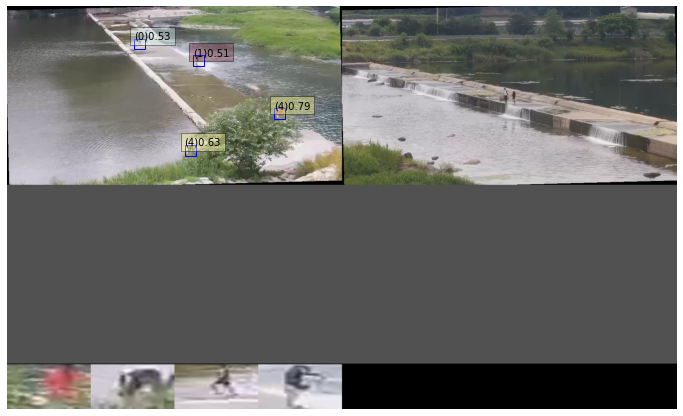

In [98]:
check_test(input_list_train, bbox_list_train, step=500)

In [ ]:
check_test(dataset_test, bbox_list_test, step=500)